# Scrape data from teamrankings.com
We are starting with the easy part of scraping the team rankings website into a pandas dataframe and appending this data into a csv file for further cleaning. This will be the start of the data that will be fed into our model

In [3]:
import pandas as pd
from datetime import datetime, timedelta
import os

# Function that appends the no runs first innings to a specfic csv file
# Made it like this because I kept getting rate limited so I just scrape a little bit at a time
def scrape_nrfi(start_date, end_date, increment, csv_file):
    if not os.path.exists(csv_file):
        print('file does not exist')
        return
    
    all_dfs = []
    
    while start_date <= end_date:
        date_str = start_date.strftime("%Y-%m-%d")
        url = f"https://www.teamrankings.com/mlb/stat/no-run-first-inning-pct?date={date_str}"
    
        try:
            df = pd.read_html(url)[0]
            df["date"] = date_str
            df.to_csv(csv_file, mode='a', header=False, index=False)
            start_date += delta  
            print(f"Scraped and saved data for {date_str}")
        except Exception as e:
            print(f"Failed on {date_str}: {e}")
    return




In [4]:
# calling the scrape function
start = datetime.strptime("2021-03-01", "%Y-%m-%d")
end = datetime.strptime("2022-03-01", "%Y-%m-%d")

delta = timedelta(days=15)
file = 'nrfi_data.csv'

scrape_nrfi(start, end, delta, file)

Scraped and saved data for 2021-03-01
Scraped and saved data for 2021-03-16
Scraped and saved data for 2021-03-31
Scraped and saved data for 2021-04-15
Scraped and saved data for 2021-04-30
Scraped and saved data for 2021-05-15
Scraped and saved data for 2021-05-30
Scraped and saved data for 2021-06-14
Scraped and saved data for 2021-06-29
Scraped and saved data for 2021-07-14
Scraped and saved data for 2021-07-29
Scraped and saved data for 2021-08-13
Scraped and saved data for 2021-08-28
Scraped and saved data for 2021-09-12
Scraped and saved data for 2021-09-27
Scraped and saved data for 2021-10-12
Scraped and saved data for 2021-10-27
Scraped and saved data for 2021-11-11
Scraped and saved data for 2021-11-26
Scraped and saved data for 2021-12-11
Scraped and saved data for 2021-12-26
Scraped and saved data for 2022-01-10
Scraped and saved data for 2022-01-25
Scraped and saved data for 2022-02-09
Scraped and saved data for 2022-02-24


In [5]:
import pandas as pd

# Read saved csv of scraped data
df = pd.read_csv('nrfi_data.csv')
# Ended up with some duplicate dates because when scraping different time ranges accidentally used the same date a couple times
nrfi_df = df.drop_duplicates(subset=['Team', 'date']).copy()
nrfi_df.to_csv('nrfi_data_deduped.csv', index=False)
nrfi_df

,Rank,Team,2023,Last 3,Last 1,Home,Away,2022,date,2024,2025
0,1,Atlanta,60.84%,100.00%,100.00%,51.81%,69.88%,75.30%,2024-03-01,NaN,NaN
1,2,LA Dodgers,61.82%,100.00%,100.00%,60.24%,63.41%,65.06%,2024-03-01,NaN,NaN
2,3,Tampa Bay,62.80%,66.67%,100.00%,60.24%,65.43%,71.95%,2024-03-01,NaN,NaN
3,4,San Diego,62.96%,66.67%,100.00%,62.03%,63.86%,73.56%,2024-03-01,NaN,NaN
4,5,Houston,64.16%,0.00%,0.00%,63.22%,65.12%,65.71%,2024-03-01,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4555,26,Miami,75.31%,66.67%,0.00%,66.67%,83.95%,76.92%,2022-02-24,NaN,NaN
4556,27,NY Yankees,76.69%,66.67%,100.00%,77.78%,75.61%,62.69%,2022-02-24,NaN,NaN
4557,28,Detroit,80.25%,66.67%,0.00%,74.07%,86.42%,75.86%,2022-02-24,NaN,NaN
4558,29,Texas,81.48%,66.67%,100.00%,80.25%,82.72%,76.67%,2022-02-24,NaN,NaN


# Cleaning the scraped data
Now that we scraped the data we needed, we can begin cleaning it up.
1. Turn string percentages into useable floats
2. Rename columns so the name makes more sense
3. Add a new field `rolling_last_3_avg` to smooth out the gaps in between our 10 day data scrapes. rolling_last_3_avg is a smoothed version of the last_3 stat, which already represents NRFI performance over the team’s last 3 games. Because I collect data every 10 days, this rolling average helps me smooth out noise between snapshots and better capture team trends over time. Calculated by taking the mean of the previous 3 `last_3` stat 
4. Add `nrfi_hit` label, this label will be used by the model to learn patterns and predict if a nrfi is likely to happen given rolling_last_3_avg, last_3, last_1, nrfi_2023, nrfi_2022, home, away. The label is created by looking at the n+1th snapshot and determining if the previous game (last_1) received a no run first inning. For example, `nrfi_hit` for row n will be 1 if `last 1` at row n+1 = 1

In [6]:
import numpy as np

# % strings convert to float to actrually be able to use them
# made this a function because i can see myself adding more fields and needing to run this again
def clean_percent_columns(df):
    percent_cols = ['2021','2022', '2023', '2024', '2025', 'Last 3', 'Last 1', 'Home', 'Away']
    for col in percent_cols:
        if col in df.columns:
            df[col] = df[col].astype(str).str.replace('%', '', regex=False).replace('--', np.nan)
            df[col] = pd.to_numeric(df[col], errors='coerce') / 100
    return df

clean_df = clean_percent_columns(nrfi_df)
clean_df.rename(columns={
    "2021": "nrfi_2021",
    "2022": "nrfi_2022",
    "2023": "nrfi_2023",
    "Last 3": "last_3",
    "Last 1": "last_1",
    "Home": "home",
    "Away": "away",
    "Team": "team"
}, inplace=True)

clean_df = clean_df.sort_values(by=['team', 'date'])
# Apply rolling average to smooth out the gaps between the 10 day snapshots
clean_df['rolling_last_3_avg'] = clean_df.groupby('team')['last_3'].transform(lambda x: x.rolling(3, min_periods=1).mean())
clean_df.to_csv('test_percent_clean.csv')




In [ ]:
# Creating nrfi_hit label for training model (step 4)
labeled_df = clean_df.sort_values(by=['team', 'date']).copy()

# Create the label by taking the next snapshot's last_1 value, this is just an estimate for now since our data takes a snapshot every 10 days
# For each team, we need the next snapshot's last_1 value, and assign it to the current row, we can do that with the shift() function
# Using Int64 so I can let the NANs exist for now, don't want to drop them yet
labeled_df['nrfi_hit'] = labeled_df.groupby('team')['last_1'].shift(-1).round().astype('Int64')
labeled_df.to_csv('full_dataset_nrfi.csv')
labeled_df

# Data Visualization
Visualize this data to see if we can spot any weird outliers or mistakes in the cleaning process!

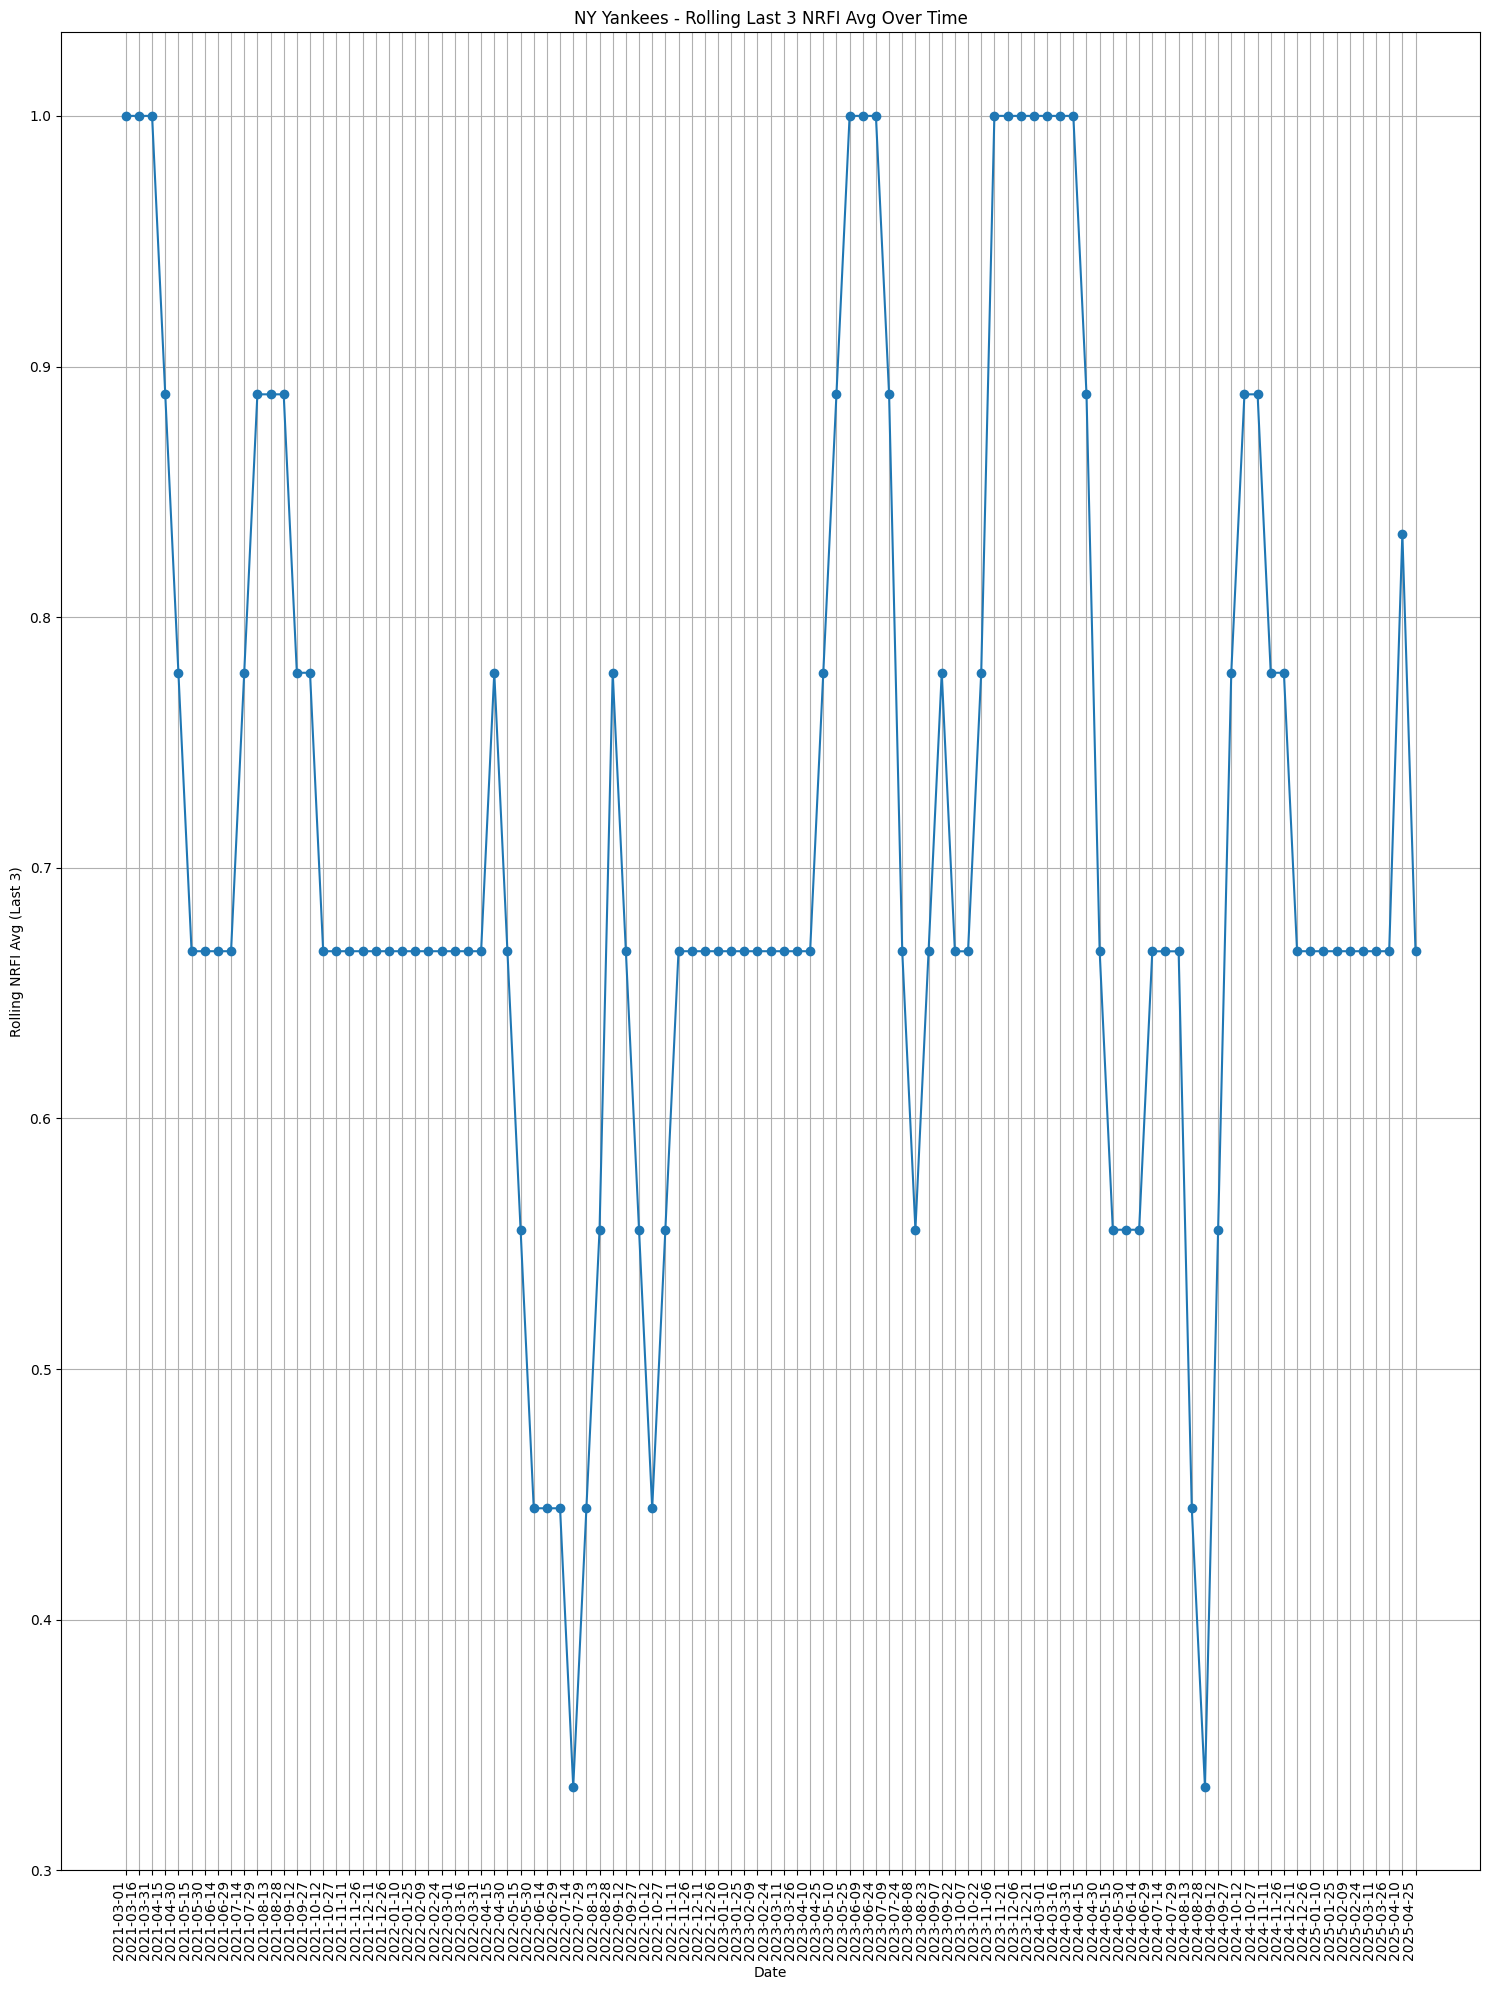

In [20]:
# Individual team visualization
import matplotlib.pyplot as plt

team_name = 'NY Yankees'

team_df = clean_df[clean_df['team'] == team_name]

plt.figure(figsize=(15, 20))
plt.plot(team_df['date'], team_df['rolling_last_3_avg'], marker='o')
plt.title(f"{team_name} - Rolling Last 3 NRFI Avg Over Time")
plt.xlabel('Date')
plt.xticks(rotation=90, ha='right')
plt.ylabel('Rolling NRFI Avg (Last 3)')
plt.grid(True)
plt.tight_layout()
plt.show()

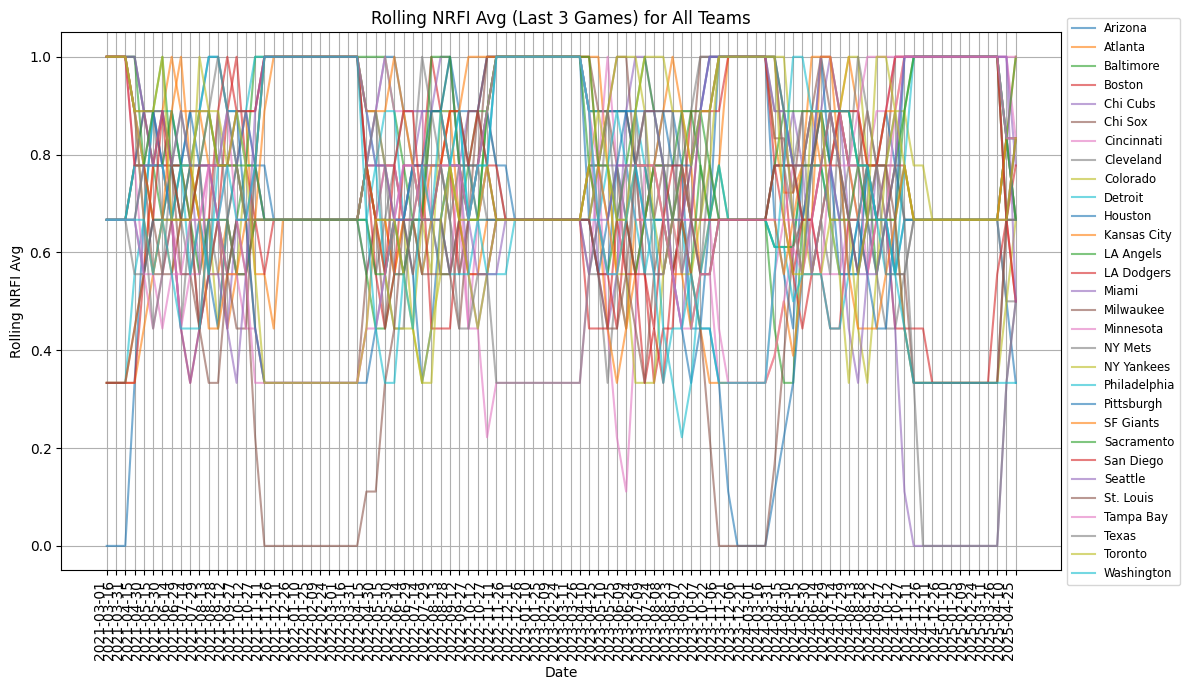

In [41]:
# All teams rolling average of no run in first innings, looking at this graph below, 
# most of the cluster is between 60% to 80%, this leads me to believing that no run first hitting would hit at least 1-2 times every 3 games
plt.figure(figsize=(12, 7))

for team in clean_df['team'].unique():
    team_df = clean_df[clean_df['team'] == team]
    plt.plot(team_df['date'], team_df['rolling_last_3_avg'], alpha=0.6, label=team)

plt.title('Rolling NRFI Avg (Last 3 Games) for All Teams')
plt.xlabel('Date')
plt.xticks(rotation=90, ha='right')
plt.ylabel('Rolling NRFI Avg')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
# sanity check for duplicates
dupes = clean_df[clean_df.duplicated(subset=['team', 'date'], keep=False)]
dupes = dupes.sort_values(by=['team', 'date'])

dupes
# clean_df.groupby(['team', 'date']).size().reset_index(name='count').query('count > 1')


,Rank,team,nrfi_2023,last_3,last_1,home,away,nrfi_2022,date,2024,2025,rolling_last_3_avg


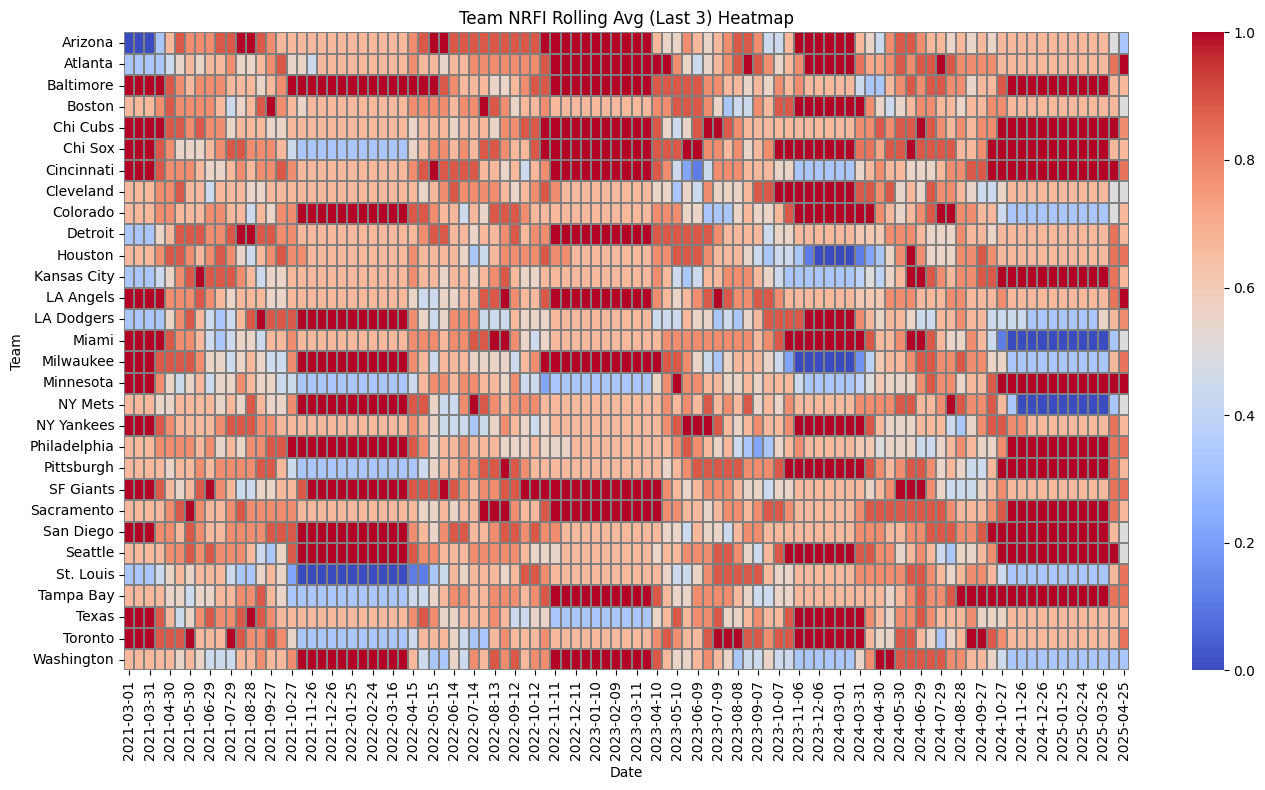

In [43]:
# matrix of teams vs dates to visualize team's rolling NRFI average (used last_3) on a specific snapshot date
# Redder (hot) means value closer to 1.0 team consistently allowing no runs in 1st inning
# Bluer (cold) means value closer to 0.0 team frequently allowing 1st-inning runs
# White/light is middle performance (around 0.5)
# We are looking for teams that have shown consistent red throughout the years
import seaborn as sns

pivot_df = clean_df.pivot(index='team', columns='date', values='rolling_last_3_avg')

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_df, cmap='coolwarm', linewidths=0.3, linecolor='gray')
plt.title('Team NRFI Rolling Avg (Last 3) Heatmap')
plt.xlabel('Date')
plt.ylabel('Team')
plt.tight_layout()
plt.show()


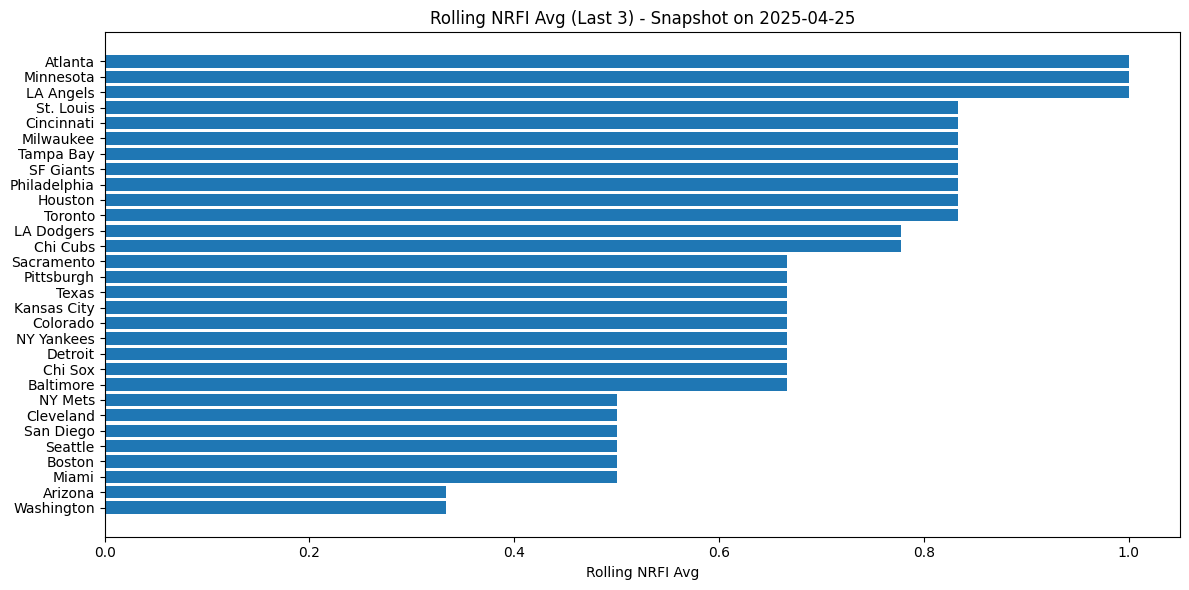

In [44]:
# Show how all teams compare at the most recent date
latest_date = clean_df['date'].max()
latest_df = clean_df[clean_df['date'] == latest_date].sort_values(by='rolling_last_3_avg', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(latest_df['team'], latest_df['rolling_last_3_avg'])
plt.title(f"Rolling NRFI Avg (Last 3) - Snapshot on {latest_date}")
plt.xlabel('Rolling NRFI Avg')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


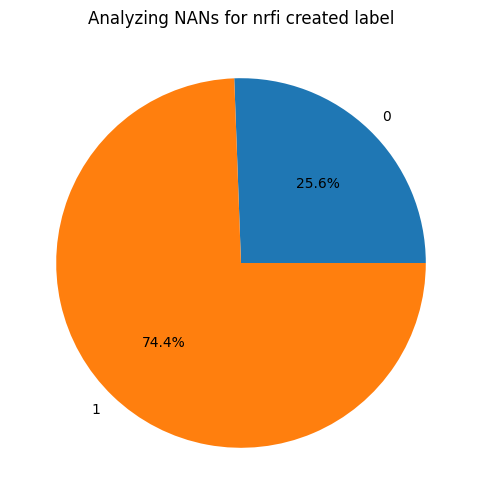

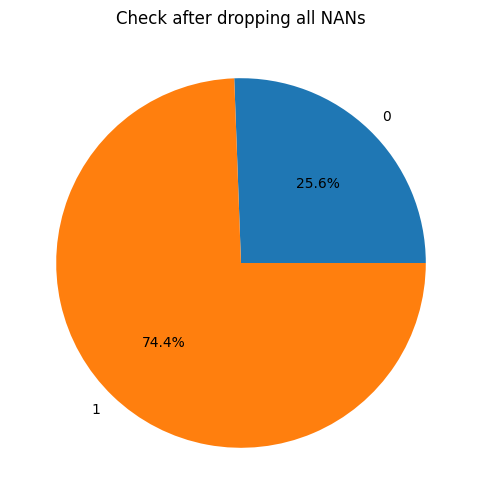

In [31]:
# Visualize new nrfi_hit label we added, ideally would like to see mostly 1 or 0 with minimal nan
# Count 0s, 1s, and NaNs

label_counts = labeled_df['nrfi_hit'].value_counts(dropna=False).sort_index()

plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=label_counts.index.astype(str), autopct='%1.1f%%')
plt.title('Analyzing NANs for nrfi created label')
plt.show()

# Only 2% of the data is showing up as NA so I feel comfortable dropping the NA labels for nrfi_hit
labeled_df = labeled_df.dropna(subset=['nrfi_hit'])
label_counts = labeled_df['nrfi_hit'].value_counts(dropna=False).sort_index()

plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=label_counts.index.astype(str), autopct='%1.1f%%')
plt.title('Check after dropping all NANs')
plt.show()
# Ready to split into train, test
labeled_df.to_csv('full_dataset_nrfi_noNAN.csv')

# Aggregating team specifics to create valuable label for model to train
The plan: I wanted to aggregate the opponent the team was playing to every row by using pybaseball but it has not been maintained for a few years. I applied to use the MLB stats API so for now I am going to skip this idea and just use what I have. 

Eventually I would like to include more specifics like team names and include more data on top of the 10 day snapshots

TODO

In [ ]:
from pybaseball import schedule_and_record, team_game_logs

seasons = [2021, 2022, 2023, 2024]
teams   = ['ARI','ATL']

all_logs = []

# Loop through each team/season and grab batting logs
for year in seasons:
    for team in teams:
        df = team_game_logs(year, team, log_type='batting')
        df['season'] = year
        df['team']   = team
df


# Training the model
I am going to use an XGBoost model. After doing research the best options were logistic regression, random forest and XGBoost.

XGBoost is a gradient boosted decision tree https://xgboost.readthedocs.io/en/release_3.0.0/tutorials/model.html

After evaluating logistic regression, random forest, and XGBoost, I chose XGBoost because it balances speed, accuracy, and flexibility.
It handles numeric features well, models nonlinear interactions automatically (unlike logistic regression), and includes built-in regularization to prevent overfitting (L1 and L2 params) .
It also returns probability outputs, which are useful for making risk-aware decisions. With only ~3,000 rows and fewer than 10 features, XGBoost is a perfect match for this structured problem.


More information: https://www.datacamp.com/courses/extreme-gradient-boosting-with-xgboost


In [8]:
# 2021-03-01 to 2023-12-21 will be used for training, last half of 2024 season will be used for tesiting
# This leaves us with 20% of the data to test, ideally I would like to have more data but it is what it is
from sklearn.model_selection import train_test_split

labeled_df = pd.read_csv('full_dataset_nrfi_noNAN.csv')
train_df = labeled_df[labeled_df['date'] <= '2024-07-29']
test_df = labeled_df[labeled_df['date'] > '2024-07-29']
print(len(train_df))
print(len(test_df))

2430
482


In [30]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score
import pandas as pd

# features to be used, can't use team name because it is not numerical
# It can also cause overfitting by learning patterns that aren't useful
# Will include team names if I can get more data and append who opponents are to data
features = [
    'rolling_last_3_avg', 'last_3', 'last_1',
    'nrfi_2023', 'nrfi_2022', 'home', 'away'
]


X_train = train_df[features]
y_train = train_df['nrfi_hit']

X_test = test_df[features]
y_test = test_df['nrfi_hit']

# convert pd dataframe to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_test, label=y_test)

# Set model parameters
params = {
    'objective': 'binary:logistic', # Binary classification with probabilities
    'eval_metric': 'logloss', # Focus on probability quality
    'max_depth': 3, # max depth of tree. 3-6 is common for small dataset, got best results with 3
    'eta': 0.1, # Learning rate
    'seed': 42 # random number seed
}

# Train model
model = xgb.train(params, dtrain, num_boost_round=100)

# Predict on test set
y_pred_prob = model.predict(dtest)
# Turn predictions into a yes or no with 60% certainty as threshold to be more cautious
y_pred = (y_pred_prob >= 0.60).astype(int)

# Evaluation using Accuracy and Receiver Operating Characteristic (Area Under the Curve)
# ROC gives a direct ration for true positive rate vs false positive rate, This model received an ROC of 85 which is noice
print(f'Accuracy: {accuracy_score(y_test, y_pred):.3f}')
print(f'ROC AUC:  {roc_auc_score(y_test, y_pred_prob):.3f}')

Accuracy: 0.846
ROC AUC:  0.852


In [31]:
# save the model
model.save_model('nrfi_model.json')


In [35]:
# How to use the model

# load
loaded_model = xgb.XGBClassifier()
loaded_model.load_model('nrfi_model.json')

# random data to predict
X_new = pd.DataFrame([{
    'rolling_last_3_avg': 0.72,
    'last_3': 0.67,
    'last_1': 1.0,
    'nrfi_2023': 0.76,
    'nrfi_2022': 0.74,
    'home': 0.63,
    'away': 0.71
}])

dnew = xgb.DMatrix(X_new)

y_pred_prob = model.predict(dnew)
y_pred = (y_pred_prob >= 0.6).astype(int)
print(f'Predicted NRFI probability: {y_pred_prob[0]:.2%}')


Predicted NRFI probability: 57.86%
